Phase 4 Project - Kaggle Competition "Natural Language Processing with Disaster Tweets"

Sentiment Classification on twitter data

## Business Problem

Data has been accumulated from a number of tweets, some of which are about disasters, some of which are not. By creating a model for Natural Language Processing (NLP), we can predict whether or not a given tweet is about a real disaster or not. This can benefit companies who wish to monitor twitter in the event of an emergency.

## Data Understanding

Necessary imports:


In [39]:
import pandas as pd 
import numpy as np 
np.random.seed(42)
import nltk
nltk.download('punkt')
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from nltk import FreqDist
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nicolemichaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### Data Exploration:

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
# I won't be working with the 'location' column, so I'll just drop that.
train_df = train_df.drop(columns = ['location'])
test_df = test_df.drop(columns = ['location'])
train_df.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df['text'].dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7613 non-null   int64 
 1   keyword  7552 non-null   object
 2   text     7613 non-null   object
 3   target   7613 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.0+ KB


In [8]:
test_df['text'].dropna(inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3263 non-null   int64 
 1   keyword  3237 non-null   object
 2   text     3263 non-null   object
dtypes: int64(1), object(2)
memory usage: 76.6+ KB


In [9]:
# Example of what is NOT a disaster tweet:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [10]:
# Example of what IS a disaster tweet:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

###### Visualizing what proportion of the training data are disaster tweets and non-disaster tweets

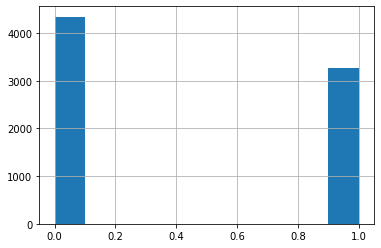

In [11]:
train_df['target'].hist();

## Data Preparation

#### Cleaning text data:
need to remove urls, tags (contain @), stopwords, punctuation, etc.

In [12]:
# Removing stopwords, punctuation, numbers, and bad characters 
# Stopwords removed during pipeline instead ? 

stopwords_list = stopwords.words('english')

no_bad_chars = re.compile('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n - ]')
no_nums = re.compile('[\d-]')

def clean_text(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    text = ' '.join(word for word in text.split() if word not in stopwords_list)
    return text
    

train_df_cleaned = train_df['text'].apply(clean_text)
#train_df_cleaned = pd.DataFrame.sparse.from_spmatrix(train_df_cleaned)
test_df_cleaned = test_df['text'].apply(clean_text)
#test_df_cleaned = pd.DataFrame.sparse.from_spmatrix(test_df_cleaned)
train_df_cleaned.head(10) 




0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked 'shelter place' notified offic...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
5    rockyfire update california hwy closed directi...
6    flood disaster heavy rain causes flash floodin...
7                          i'm top hill see fire woods
8    there's emergency evacuation happening buildin...
9                       i'm afraid tornado coming area
Name: text, dtype: object

___________


###### Calculating the probabilities of disaster and non-disaster tweets in the training data:

In [13]:
disaster_tweets = train_df[train_df['target']==1]

other_tweets = train_df[train_df['target']==0]

In [14]:
P_disasters = len(disaster_tweets) /(len(disaster_tweets)+len(other_tweets))
P_non = len(other_tweets) /(len(other_tweets)+len(disaster_tweets))
print(P_disasters)
print(P_non)

0.4296597924602653
0.5703402075397347


This tells us that tweets in train_df have a higher probability of not being about a disaster.

_______

In [15]:
X = train_df.text
y = train_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [16]:
X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned = X_test.apply(clean_text)

In [17]:
# Keep this cell??
# Move to Misc.?

# Tokenizing the data:
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

train_df_tokenized = train_df_cleaned.copy()
test_df_tokenized = test_df_cleaned.copy()
train_df_tokenized = train_df_cleaned.apply(tokenizer.tokenize)
test_df_tokenized = test_df_cleaned.apply(tokenizer.tokenize)


In [18]:
# Keep this cell??
# Move to Misc.?


#X_train_tokenized = X_train_cleaned.apply(tokenizer.tokenize)
#X_test_tokenized = X_test_cleaned.apply(tokenizer.tokenize)

#X_train_tokenized.explode()
#X_test_tokenized.explode()

In [19]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    


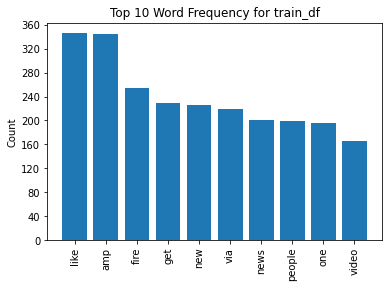

In [20]:
train_freq_dist = FreqDist(train_df_tokenized.explode())
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for train_df")

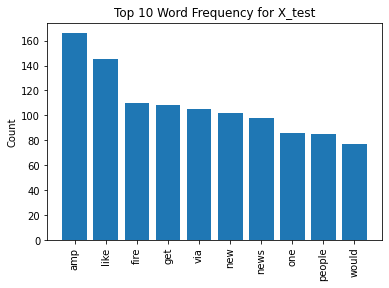

In [21]:
test_freq_dist = FreqDist(test_df_tokenized.explode())
visualize_top_10(test_freq_dist, "Top 10 Word Frequency for X_test")

Many of the most common words are the same in both the training df and the test df.

In [22]:
#Need to do this visualization for target=1 and target=0 of train_df

In [23]:
disaster_tweets_cleaned = disaster_tweets['text'].apply(clean_text)
other_tweets_cleaned = other_tweets['text'].apply(clean_text)

In [24]:
disaster_tweets_tokenized = disaster_tweets_cleaned.apply(tokenizer.tokenize)
other_tweets_tokenized = other_tweets_cleaned.apply(tokenizer.tokenize)


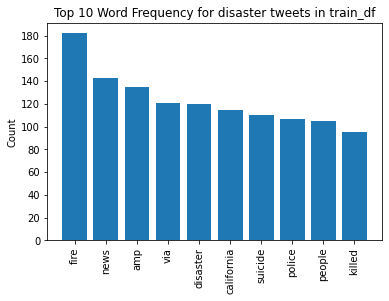

In [25]:
dis_tweets_freq_dist = FreqDist(disaster_tweets_tokenized.explode())
visualize_top_10(dis_tweets_freq_dist, "Top 10 Word Frequency for disaster tweets in train_df")

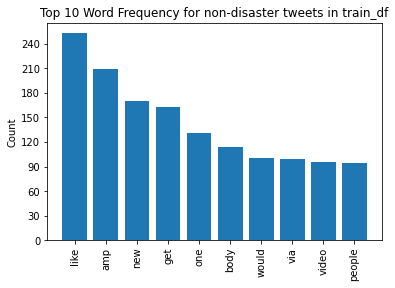

In [26]:
other_tweets_freq_dist = FreqDist(other_tweets_tokenized.explode())
visualize_top_10(other_tweets_freq_dist, "Top 10 Word Frequency for non-disaster tweets in train_df")

###### Building a baseline model

In [27]:
baseline_model = Pipeline([('vect', CountVectorizer(max_features=None,
                                                    tokenizer=word_tokenize,
                                                   stop_words=stopwords_list)),
                           ('clf', MultinomialNB())
              ])
baseline_model.fit(X_train_cleaned, y_train)


y_pred = baseline_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred, y_test, average="macro"))
print(classification_report(y_test, y_pred))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7980290172460991
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.80      0.73      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.80      0.80      1904
weighted avg       0.80      0.80      0.80      1904



In [28]:
# Model with bigrams:
baseline_model = Pipeline([('vect', CountVectorizer(max_features=None,
                                                    tokenizer=word_tokenize,
                                                   stop_words=stopwords_list,
                                                   ngram_range=(1,2))),
                           ('clf', MultinomialNB())
              ])
baseline_model.fit(X_train_cleaned, y_train)


y_pred = baseline_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred, y_test, average="macro"))
print(classification_report(y_test, y_pred))




/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7952741308160336
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.79      0.73      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904



In [29]:
# model with TF-IDF Vectorizer instead of CountVectorizer

model2 = Pipeline([('vect', TfidfVectorizer(tokenizer=word_tokenize,
                                           stop_words=stopwords_list)),
                   ('clf', MultinomialNB()),
                  ])
model2.fit(X_train_cleaned, y_train)


from sklearn.metrics import classification_report
y_pred2 = model2.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred2, y_test, average="macro"))
print(classification_report(y_test, y_pred2))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7917740240719726
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1091
           1       0.84      0.67      0.74       813

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.81      0.80      0.80      1904



In [30]:
#when stemming/lemmatizing, we are going to do the same to the stopwords, so we don't want to remove them before this
def clean_text_nostop(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    #text = ' '.join(word for word in text.split() if word not in stopwords_list)
    return text
    
train_df_cleaned_nostop = train_df.copy()

train_df_cleaned_nostop['text'] = train_df_cleaned_nostop['text'].apply(clean_text_nostop)

X_nostop = train_df_cleaned_nostop.text
y_nostop = train_df_cleaned_nostop.target
X_train_nostop, X_test_nostop, y_train_nostop, y_test_nostop = train_test_split(X_nostop, y_nostop, test_size=0.25, random_state = 42)


In [31]:
# Stemming the text to see if it improves our model
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [32]:
#Stemmed data model
stem_model = Pipeline([('vect', CountVectorizer(
                         stop_words=stemmed_stopwords,
                         tokenizer=stem_and_tokenize)),
               ('clf', MultinomialNB()),
              ])
stem_model.fit(X_train_nostop, y_train_nostop)


from sklearn.metrics import classification_report
y_pred_stem= stem_model.predict(X_test_nostop)

print('F1 %s' % f1_score(y_pred_stem, y_test_nostop, average="macro"))
print(classification_report(y_test_nostop, y_pred_stem))

F1 0.7995784912170498
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.79      0.74      0.76       813

    accuracy                           0.81      1904
   macro avg       0.80      0.80      0.80      1904
weighted avg       0.81      0.81      0.80      1904



In [33]:
#What about lemmatization?
lemmatizer = WordNetLemmatizer() 

def lem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(token) for token in tokens]


lemm_stopwords = [lemmatizer.lemmatize(word) for word in stopwords_list]

In [34]:
# Lemmatized data model
lemm_model = Pipeline([('vect', CountVectorizer(
                         stop_words=lemm_stopwords,
                         tokenizer=lem_and_tokenize)),
                       ('clf', MultinomialNB()),
              ])
lemm_model.fit(X_train_nostop, y_train_nostop)


from sklearn.metrics import classification_report
y_lemm_pred= lemm_model.predict(X_test_nostop)

print('F1 %s' % f1_score(y_lemm_pred, y_test_nostop))
print(classification_report(y_test_nostop, y_lemm_pred))

F1 0.7612412919569347
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1091
           1       0.78      0.74      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904



The best model was the stemmed model.

______

#### Attempting GridSearch:

In [35]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_cleaned)
X_test_vectorized = vectorizer.transform(X_test_cleaned)

# Which do I use?? The whole train_df or just X_train?

#train_df_vectorized = tfidf.fit_transform(train_df)
#test_df_vectorized = tfidf.transform(test_df)

#pd.DataFrame.sparse.from_spmatrix(train_df_vectorized, columns=vectorizer.get_feature_names())

In [37]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train_cleaned)
X_train_vec  = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)


X_test_vec = cv.transform(X_test_cleaned)
X_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [38]:
#GridSearchCV
alphas = [0.5, 1.0, 1.5, 2.0, 2.5]
p_grid_NB = {'alpha': alphas, 'fit_prior' : [True, False]}
NB_cls= MultinomialNB()

grid = GridSearchCV(estimator = NB_cls, param_grid = p_grid_NB, scoring = 'f1', cv = 3)
grid.fit(X_train_vec, y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 1.0, 1.5, 2.0, 2.5],
                         'fit_prior': [True, False]},
             scoring='f1')

Explanation for hyperparams:
- alpha specifies whether or not to use smoothing/ it is the additive smoothing parameter (0=No smoothing)

- class prior is the prior probability of the classes. Default is None.  If specified the priors are not adjusted according to the data.

- fit prior specifies whether to learn class prior probabilities or not. If false, a uniform prior will be used.

In [39]:
grid.best_params_

{'alpha': 2.0, 'fit_prior': True}

In [36]:
tuned_model = Pipeline([('vect', CountVectorizer(
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize,
    ngram_range = (1,3))),
                        ('clf', MultinomialNB(alpha= 2.0,fit_prior = True)),
              ])
tuned_model.fit(X_train_nostop, y_train_nostop)


from sklearn.metrics import classification_report
y_pred_tuned= tuned_model.predict(X_test_nostop)

print('F1 %s' % f1_score(y_pred_tuned, y_test_nostop, average="macro"))
print(classification_report(y_test_nostop, y_pred_tuned))

F1 0.8015542480543345
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1091
           1       0.80      0.73      0.76       813

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



In [37]:
cnf_matrix = confusion_matrix(y_test_nostop, y_pred_tuned)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[945 146]
 [219 594]]


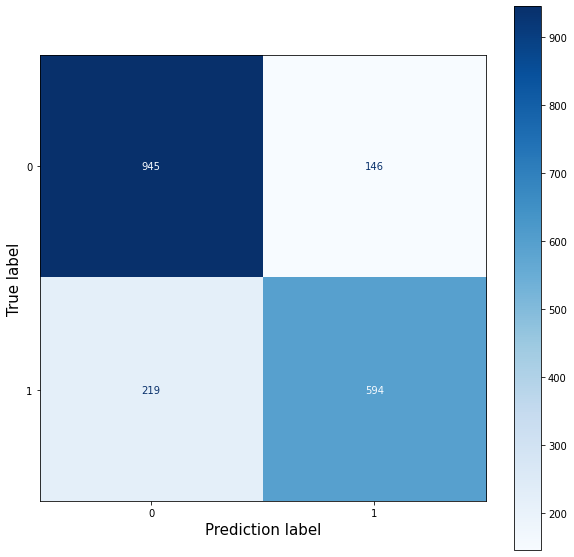

In [42]:
#CM Visualization:
fig, ax = plt.subplots(figsize=(10,10))
cm_1 = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = tuned_model.classes_)
cm_1.plot(cmap=plt.cm.Blues, ax=ax)
plt.xlabel('Prediction label',fontsize=15)
plt.ylabel('True label',fontsize=15);

This model gave 945 True Positives, 594 True Negatives, 146 False Negatives, and 219 False Positives. In this case, it would be better to have a false positive than a false negative, so this is good.

______

In [41]:
#np.logspace(0,-9, num=10)

In [42]:
#from sklearn.model_selection import RepeatedStratifiedKFold

#cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

IndentationError: unexpected indent (<ipython-input-42-a2825fe428c7>, line 4)

In [ ]:
#model = MultinomialNB()

In [ ]:
#from sklearn.preprocessing import PowerTransformer
#params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

#gs_NB = GridSearchCV(estimator=model, 
                     #param_grid=params_NB, 
                     #cv=cv_method,
                     #verbose=1, 
                     #scoring='accuracy')

#Data_transformed = PowerTransformer().fit_transform(X_test)

#gs_NB.fit(Data_transformed, y_test);

In [ ]:
#from sklearn.preprocessing import MultiLabelBinarizer
#model4 = Pipeline([('vect', MultiLabelBinarizer()),
               #('clf', MultinomialNB()),
              #])
#model4.fit(X_train, y_train)


#y_pred4 = model4.predict(X_test)

#print('accuracy %s' % accuracy_score(y_pred4, y_test))
#print(classification_report(y_test, y_pred4))



## Generating Predictions

After building baseline model, try things to improve score

In [43]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [44]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


Before creating predictions on the sample submission csv, I want to try it on the test_df to make sure it works:


In [45]:
def clean_text_nostop(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    return text
    
test_df_cleaned_nostop = test_df.copy()

test_df_cleaned_nostop['text'] = test_df_cleaned_nostop['text'].apply(clean_text_nostop)


In [46]:
test_df_cleaned_nostop

,id,keyword,text
0,0,NaN,just happened a terrible car crash
1,2,NaN,heard about earthquake is different cities s...
2,3,NaN,there is a forest fire at spot pond geese are...
3,9,NaN,apocalypse lighting spokane wildfires
4,11,NaN,typhoon soudelor kills in china and taiwan
...,...,...,...
3258,10861,NaN,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,storm in ri worse than last hurricane my city...
3260,10868,NaN,green line derailment in chicago
3261,10874,NaN,meg issues hazardous weather outlook hwo


In [47]:
test_df_sample = test_df_cleaned_nostop.copy()
test_df_sample['target'] = tuned_model.predict(test_df_sample['text'])

In [48]:
test_df_sample

,id,keyword,text,target
0,0,NaN,just happened a terrible car crash,1
1,2,NaN,heard about earthquake is different cities s...,1
2,3,NaN,there is a forest fire at spot pond geese are...,1
3,9,NaN,apocalypse lighting spokane wildfires,1
4,11,NaN,typhoon soudelor kills in china and taiwan,1
...,...,...,...,...
3258,10861,NaN,earthquake safety los angeles ûò safety faste...,1
3259,10865,NaN,storm in ri worse than last hurricane my city...,0
3260,10868,NaN,green line derailment in chicago,1
3261,10874,NaN,meg issues hazardous weather outlook hwo,1


In [49]:
test_df_sample['target'].value_counts()

0    2062
1    1201
Name: target, dtype: int64

This appears to have worked, so let's try it on the sample submission:

In [50]:
sample_submission["target"] = tuned_model.predict(test_df['text'])

In [51]:
sample_submission['target'].value_counts()

0    2001
1    1262
Name: target, dtype: int64

## Evaluation

In [ ]:
#Confusion matrix

In [ ]:
# neural network?

In [52]:
#POS tagging

## Conclusion

_____

In [ ]:
df1=pd.DataFrame(X_train)
df1=df1.rename(columns={0:'tweet'})

df2=pd.DataFrame(y_train)
df2=df2.rename(columns={1:'sentiment'})

df_train=pd.concat([df1,df2],axis=1)

df3=pd.DataFrame(X_test)
df3=df3.rename(columns={0:'tweet'})

df4=pd.DataFrame(y_test)
df4=df4.rename(columns={1:'sentiment'})
df_test=pd.concat([df3,df4],axis=1)

In [ ]:
df_test

In [ ]:
df_train['text'] = df_train['text'].apply(lambda x:clean_text(x))
df_test['text'] = df_test['text'].apply(lambda x:clean_text(x))

#df_test['news']= df_test['news'].apply(lambda x:remove_punctuation(x))

In [ ]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]  
  print("bigrams:",words)
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans


In [ ]:
df_train

In [ ]:
generate_N_grams("The sun rises in the east",2)

In [ ]:
from collections import defaultdict

disasterValues2=defaultdict(int)
noneValues2=defaultdict(int)
#neutralValues2=defaultdict(int)

In [ ]:
for text in df_train[df_train.target==1].text:
  for word in generate_N_grams(text,2):
    disasterValues2[word]+=1

In [ ]:
disasterValues2

In [ ]:
for text in df_train[df_train.target==0].text:
  for word in generate_N_grams(text,2):
    noneValues2[word]+=1

In [ ]:
df_disasterValues2=pd.DataFrame(sorted(disasterValues2.items(),key=lambda x:x[1],reverse=True))
df_noneValues2=pd.DataFrame(sorted(noneValues2.items(),key=lambda x:x[1],reverse=True))


In [ ]:
df_disasterValues2

In [ ]:
disd1bi=df_disasterValues2[0][:10]
disd2bi=df_disasterValues2[1][:10]

In [ ]:
non1=df_noneValues2[0][:10]
non2=df_noneValues2[1][:10]

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(disd1bi,disd2bi, color ='green',
        width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in disaster dataframe-bigram ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

In [ ]:
plt.figure(1,figsize=(16,4))
plt.bar(non1,non2, color ='red',
        width = 0.4)
plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in negative dataframe-BIGRAM ANALYSIS")
plt.savefig("negative-bigram.png")
plt.show()

In [ ]:
X_train_bigr = defaultdict(int)
X_test_bigr = defaultdict(int)
for text in train_df[train_df.target==0].text:
  for word in generate_N_grams(text,2):
    noneValues2[word]+=1


In [ ]:
baseline_model = Pipeline([('vect', CountVectorizer(max_features=None,
                                                    ngram_range = (1,2),
                                                    tokenizer=word_tokenize,
                                                   stop_words=stopwords_list)),
                           ('clf', MultinomialNB())
              ])

mnb = MultinomialNB()
mnb.fit(X_train_cleaned, y_train)
y_pred = baseline_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


